# Chronos - Basic Usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

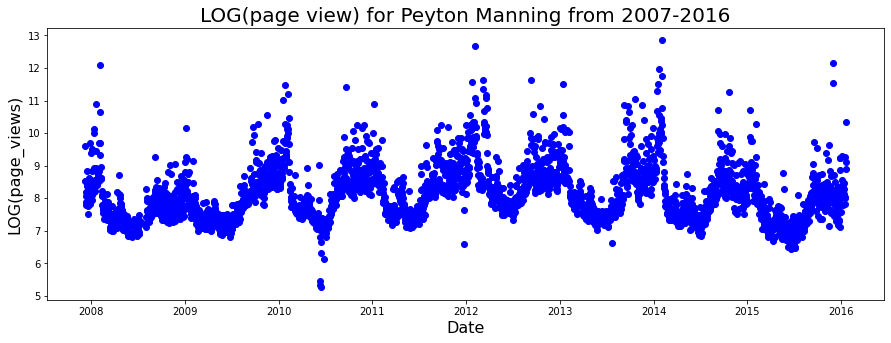

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [5]:
from chronos import Chronos

In [6]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.001,
                     distribution="StudentT", 
                     seasonality_mode="add")
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.9346                                                                         


In [7]:
future_df = my_chronos.make_future_dataframe(period=365)

In [8]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2007-12-10,9.590761,8.332505,9.253728,7.305240,7.615209,7.615209,7.615209
1,2007-12-11,8.519590,8.233799,9.271256,7.149244,7.615547,7.615583,7.615583
2,2007-12-12,8.183677,8.157706,9.376750,7.176593,7.615989,7.615957,7.615957
3,2007-12-13,8.072467,8.088970,8.973759,7.129225,7.616316,7.616330,7.616330
4,2007-12-14,7.893572,8.049591,9.155463,7.033176,7.616757,7.616703,7.616703


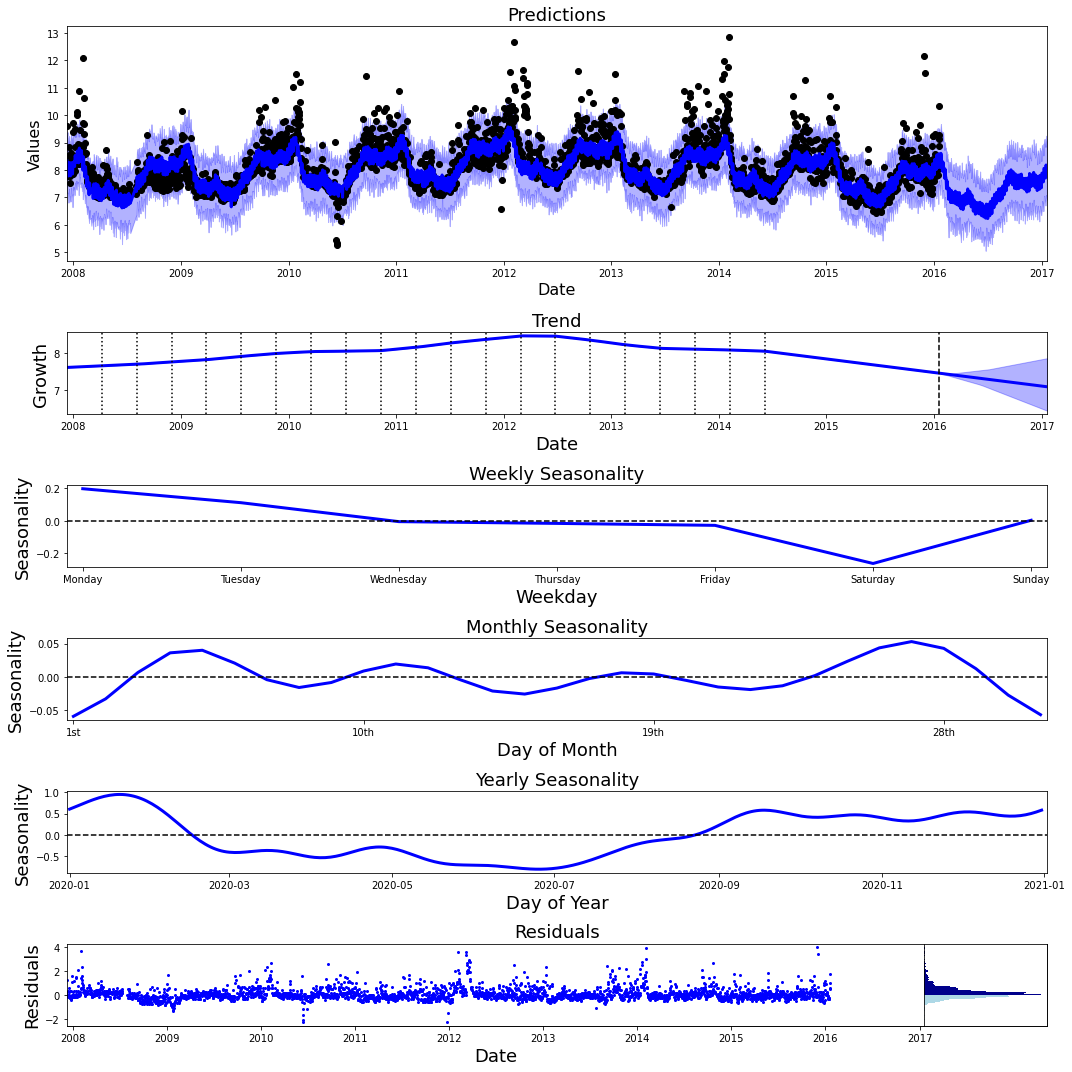

In [9]:
my_chronos.plot_components(predictions);

In [10]:
assert(False)

AssertionError: 

## Bike Sharing Data

Coming from Chicago: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data?select=data.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
bike_data = pd.read_csv('data/data.csv')
bike_data.head()

In [ ]:
relevant_data = bike_data[['starttime', 'trip_id']]
relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])
relevant_data

In [ ]:
relevant_data['date'] = relevant_data['starttime'].dt.date
relevant_data.head()

In [ ]:
grouped_data = relevant_data.groupby('date').sum().reset_index()
grouped_data.columns = ['ds', 'y']
grouped_data['ds'] = pd.to_datetime(grouped_data['ds'])
grouped_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(grouped_data['ds'], grouped_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Trips", size=16)
plt.title(f"Trip Number Taken from Chicago's Divvy Bike Sharing Program", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.8,
                     changepoint_prior=0.1,
                     distribution="Gamma",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='D', ci_interval=0.95, period=365)

In [ ]:
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="Divvy components.png");

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
my_chronos.plot_predictions(predictions, fig, axs)
plt.title("Divvy Bike Sharing Modeled Using a Gamma Distribution", size=18)
plt.show();

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=0.1,
                     distribution="Normal",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=365)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
my_chronos.plot_predictions(predictions, fig, axs)
plt.title("Divvy Bike Sharing Modeled Using a Normal Distribution", size=18)
plt.show();

## COVID

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

In [ ]:
#canada_mask = covid_data['prname'] == 'British Columbia'
canada_mask = covid_data['prname'] == 'Ontario'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

In [ ]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid = canada_daily_covid[canada_daily_covid['y']> 0]
canada_daily_covid.head()


In [ ]:
canada_daily_covid['y']

In [ ]:
canada_daily_covid['ds'].dt.day_name().isin(["Sunday", "Saturday"]).sum()/canada_daily_covid['ds'].shape[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.001, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior=10.0,
                     distribution="Gamma",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     weekly_seasonality_order=6,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=60)

In [ ]:
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.0001, 
                     n_changepoints=25,
                     seasonality_mode="mul",
                     distribution="StudentT",
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

In [ ]:
my_chronos.plot_components(predictions, figure_name="AAPL.png", changepoint_threshold=0.3);